## 1. EDA

### 1.1 Importando as bibliotecas que serão usadas

In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from pmdarima import auto_arima

### 1.2 Carregando o dataset

In [282]:
df = pd.read_csv('sim_ts.txt',sep="\t",parse_dates=True,index_col=1)
display(df.head(10))
df.shape

,vlr,produto
date,,
2009-12-01,1.006195e+09,alimenticio
2010-01-01,9.986980e+08,alimenticio
2010-02-01,9.994182e+08,alimenticio
2010-03-01,9.900000e+08,alimenticio
2010-04-01,9.942075e+08,alimenticio
2010-05-01,9.955885e+08,alimenticio
2010-06-01,9.924226e+08,alimenticio
2010-07-01,9.930611e+08,alimenticio
2010-08-01,1.007332e+09,alimenticio


(511, 2)

In [283]:
df.index

DatetimeIndex(['2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01',
               ...
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', name='date', length=511, freq=None)

O index do dataset está sem frequência definida porque está com um linha para cada produto e tem produtos que foram vendidos no mesmo mês, ou seja, apresenta index com meses repetidos

### 1.3 Já iremos pivotar o dataset, deixando cada coluna como um produto para facilitar as análises

In [284]:
df = df.pivot(columns='produto',values='vlr')
df.index = pd.to_datetime(df.index)

# colocaremos 0 em todos os Nan porque eles aconteceram quando um produto ainda não era vendido
df.fillna(0,inplace=True)
df

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
date,,,,,
2009-12-01,1.006195e+09,666666.666667,0.000000,0.000000e+00,0.000000e+00
2010-01-01,9.986980e+08,654429.216813,0.000000,0.000000e+00,0.000000e+00
2010-02-01,9.994182e+08,622883.269217,0.000000,0.000000e+00,0.000000e+00
2010-03-01,9.900000e+08,580597.407502,0.000000,0.000000e+00,0.000000e+00
2010-04-01,9.942075e+08,539057.415731,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
2021-06-01,1.887381e+09,0.000000,0.000000,2.530390e+07,1.735395e+08
2021-07-01,1.872678e+09,0.000000,195188.511222,2.665517e+07,1.737046e+08
2021-08-01,1.899408e+09,0.000000,0.000000,2.623714e+07,1.759447e+08


Dataset está sempre considerando o faturamento no dia primeiro de cada mês de cada ano. Pode-se perceber que o shape do dataset foi reduzido para 143 linhas

### 1.4 Criando uma nova coluna no dataset que indica o total de cada mês

In [285]:
df['vlr'] = df.sum(axis=1)
df

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte,vlr
date,,,,,,
2009-12-01,1.006195e+09,666666.666667,0.000000,0.000000e+00,0.000000e+00,1.006861e+09
2010-01-01,9.986980e+08,654429.216813,0.000000,0.000000e+00,0.000000e+00,9.993524e+08
2010-02-01,9.994182e+08,622883.269217,0.000000,0.000000e+00,0.000000e+00,1.000041e+09
2010-03-01,9.900000e+08,580597.407502,0.000000,0.000000e+00,0.000000e+00,9.905806e+08
2010-04-01,9.942075e+08,539057.415731,0.000000,0.000000e+00,0.000000e+00,9.947466e+08
...,...,...,...,...,...,...
2021-06-01,1.887381e+09,0.000000,0.000000,2.530390e+07,1.735395e+08,2.086224e+09
2021-07-01,1.872678e+09,0.000000,195188.511222,2.665517e+07,1.737046e+08,2.073233e+09
2021-08-01,1.899408e+09,0.000000,0.000000,2.623714e+07,1.759447e+08,2.101590e+09


### 1.5 Analisando o tipo das colunas do dataset

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2009-12-01 to 2021-10-01
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alimenticio           143 non-null    float64
 1   auxilio_final_de_ano  143 non-null    float64
 2   bonificacao           143 non-null    float64
 3   saude                 143 non-null    float64
 4   transporte            143 non-null    float64
 5   vlr                   143 non-null    float64
dtypes: float64(6)
memory usage: 7.8 KB


todas as colunas são do tipo float

In [287]:
pd.infer_freq(df.index)

'MS'

Agora que o dataset foi pivotado, é possível verificar que o index tem frequencia mensal. Vamos inputar a frequência no index já que em alguns processos interativos uma frequencia definida ajuda a melhorar a velocidade

In [288]:
df = df.asfreq(pd.infer_freq(df.index))

In [289]:
df.index

DatetimeIndex(['2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01',
               ...
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', name='date', length=143, freq='MS')

### 1.6. Vamos olhar também as principais métricas do dataset para avaliar se não tem nenhum valor estranho

In [290]:
df.describe()

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte,vlr
count,1.430000e+02,1.430000e+02,143.000000,1.430000e+02,1.430000e+02,1.430000e+02
mean,1.387476e+09,1.021312e+06,90078.664853,8.765714e+06,9.917235e+07,1.496526e+09
std,2.965446e+08,5.505655e+05,74894.591652,1.100661e+07,8.643196e+07,3.836272e+08
min,9.900000e+08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,9.905806e+08
25%,1.122228e+09,6.068267e+05,0.000000,0.000000e+00,0.000000e+00,1.122928e+09
50%,1.364441e+09,8.808176e+05,117604.819281,0.000000e+00,1.576376e+08,1.527953e+09
75%,1.644394e+09,1.358137e+06,151067.885740,2.120727e+07,1.738642e+08,1.861295e+09
max,1.990000e+09,2.500000e+06,201331.273286,2.800000e+07,2.000000e+08,2.193340e+09


Aparentemente não tem valores estranhos (negativos, por exemplo)

Como foram colocados 0 no lugar dos Nan, isso alterou as métricas de posição e para corrigir isso vamos desconsiderar os valores <=0 e olhar as principais métricas de posição

In [291]:
df[df>0].describe()

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte,vlr
count,1.430000e+02,1.380000e+02,88.000000,5.900000e+01,8.200000e+01,1.430000e+02
mean,1.387476e+09,1.058316e+06,146377.830386,2.124571e+07,1.729469e+08,1.496526e+09
std,2.965446e+08,5.241540e+05,28628.176389,5.184529e+06,1.340913e+07,3.836272e+08
min,9.900000e+08,5.000000e+05,89211.183185,5.594537e+06,1.532707e+08,9.905806e+08
25%,1.122228e+09,6.338078e+05,125621.208472,1.917839e+07,1.616310e+08,1.122928e+09
50%,1.364441e+09,9.047253e+05,145342.680590,2.288370e+07,1.726690e+08,1.527953e+09
75%,1.644394e+09,1.371534e+06,167871.765130,2.502631e+07,1.812734e+08,1.861295e+09
max,1.990000e+09,2.500000e+06,201331.273286,2.800000e+07,2.000000e+08,2.193340e+09


Produto alimentício tem o maior ticket médio e maior quantidade de vendas. O produto auxilio de final de ano também é vendido em grande quantidade porém com um ticket médio bem inferior.

In [292]:
df.index[-1]

Timestamp('2021-10-01 00:00:00', freq='MS')

Nossa série vai até outubro de 2021

### 1.7 Fazendo um boxplot dos valores

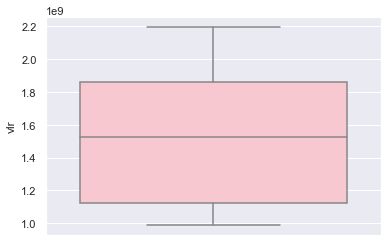

In [293]:
sns.set()

sns.boxplot(data=df,y='vlr',showfliers=True,orient='v',color='pink');

Pelo boxplot não existem outliers aparentes

### 1.8 Vamos olhar como estão distribuídos os faturamentos de cada produto

<AxesSubplot:xlabel='produto'>

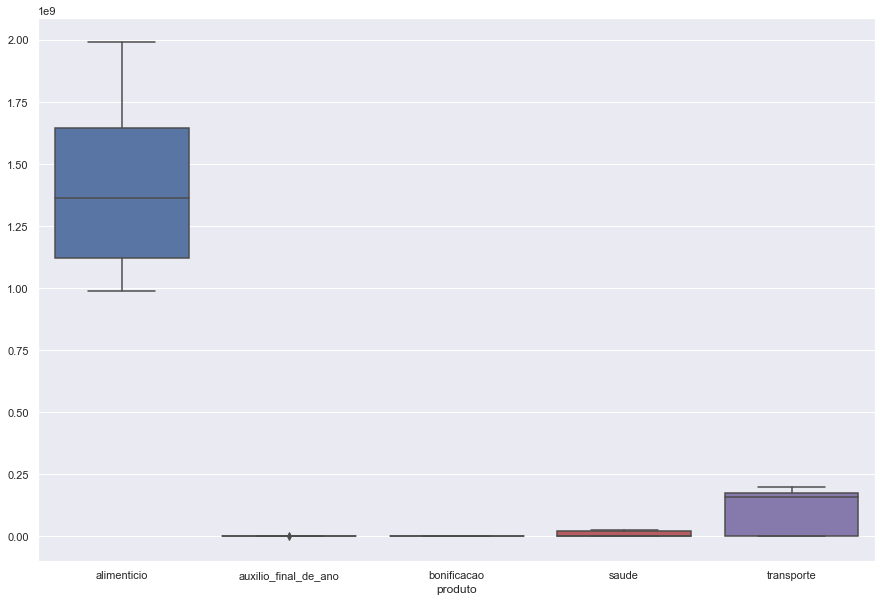

In [294]:
plt.figure(figsize=(15,10))

sns.boxplot(data=df.drop(columns='vlr'),showfliers=True)

O produto alimentício e o transporte são os que tem maior variação de faturamento, os outros produtos tem variação bem baixa. Pelo box plot fica mais evidente como o produto alimentício tem um ticket bem superior aos outros e aparentemente é o carro chefe de faturamento dessa empresa, sendo seguido pelo produto transporte.

### 1.9 Vamos olhar para como está distribuída a serie temporal dos valores

<AxesSubplot:title={'center':'Valores de faturamento ao longo dos meses'}, xlabel='date'>

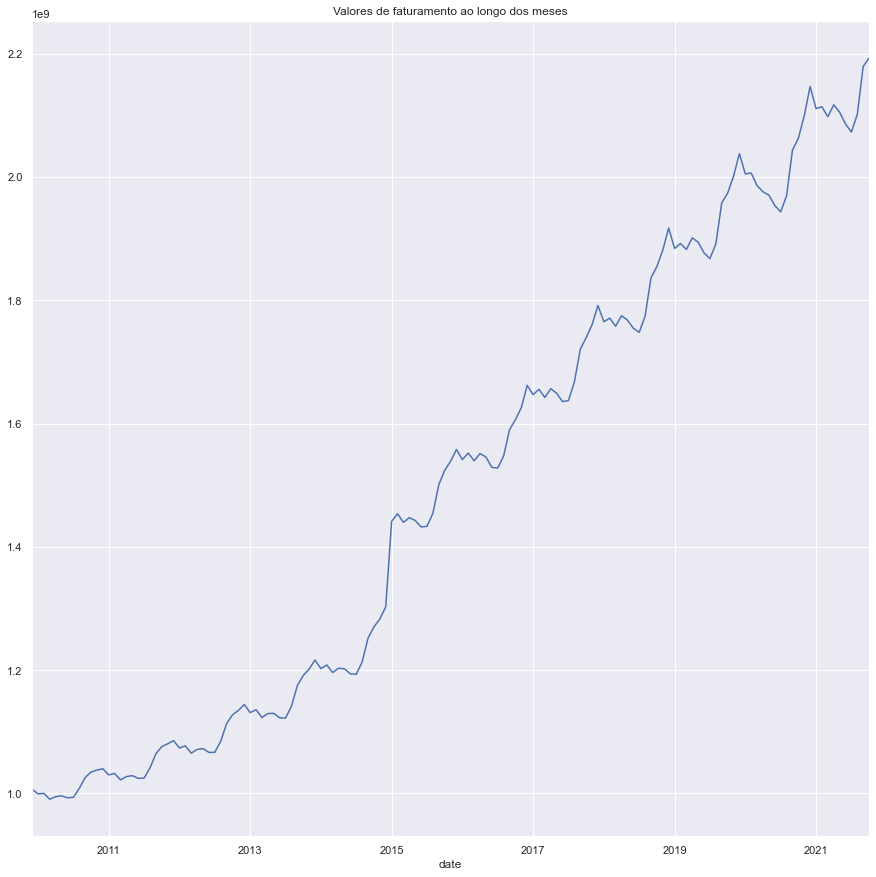

In [295]:
df['vlr'].plot(figsize=(15,15),title='Valores de faturamento ao longo dos meses')

A serie claramente apresenta tendência crescente e não é estacionaria já que tanto a sua média como a sua variância se alteram com o tempo. Parece haver um componente sazonal anual que a partir de 2015 fica mais intenso

### 1.10 Plotando a série de cada produto

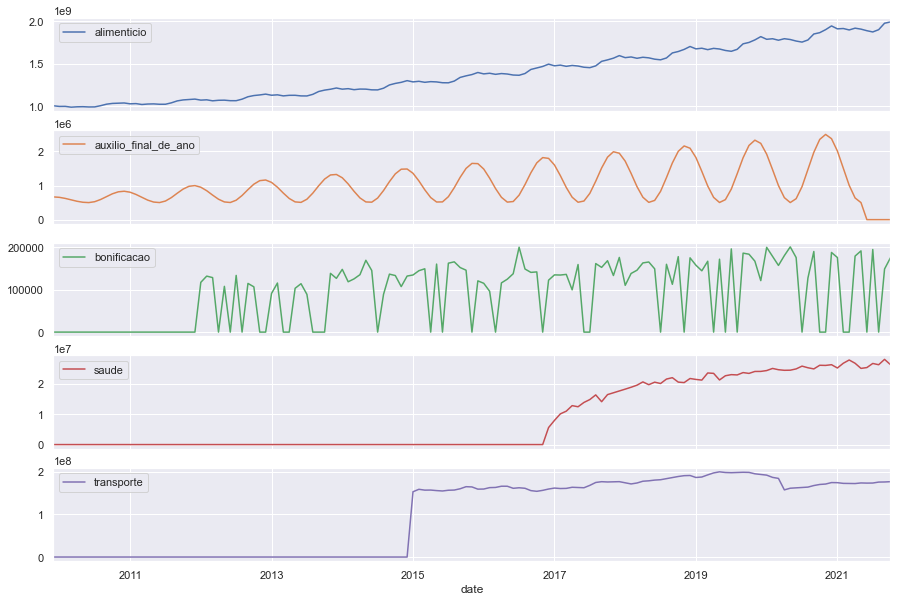

In [296]:
droped = df.drop(columns='vlr')
droped.plot(subplots=True,figsize=(15,10));

A partir dos plots é possível corroborar a escolha de colocar 0 onde haviam Nan nos produtos de saúde, transporte e bonificação já que nesses períodos não houveram vendas desses produtos. 

O produto alimentício tem o maior ticket médio e é o que é vendido a mais tempo. O segundo maior produto de ticket médio (transporte) começou a ser vendido somente em 2015, o que corrobora com a mudança do padrão sazonal comentada anteriomente observada nesse ano

As series de produtos alimentícios, auxilio de final de ano e bonificação parecem não ser estacionarias, já que a media ou a variancia não são constantes. A série de saúde apesar da variância relativamente constante tem uma média crescente sendo tendo comportamento não estacionário. O mesmo pode se dizer da série de transporte

### 1.11 Para comprovar a não estacionariedade ou a estacionariedade das séries faremos o teste de hipótese de Dickey-Fuller Aumentado

In [297]:
# Teste de Dickey Fuller
result = adfuller(df['vlr'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1] < 0.05:
    print('É Estacionário!')
else:
    print('Não é Estacionário!')

ADF Statistic: 0.452674
p-value: 0.983361
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Não é Estacionário!


Olhando para o p valor temos a comprovação matemática de que a série não é estacionaria (sem considerar a divisão por produto). Vamos olhar para as séries da diferença

In [298]:
for i in range (1,3):
    result = adfuller(np.diff(df['vlr'],i))
    print('NÚMERO DE DIFERENÇAS: ',i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] < 0.05:
        print('É Estacionário!')
    else:
        print('Não é Estacionário!')

    print(45*'*')


NÚMERO DE DIFERENÇAS:  1
ADF Statistic: -2.389397
p-value: 0.144752
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Não é Estacionário!
*********************************************
NÚMERO DE DIFERENÇAS:  2
ADF Statistic: -12.749101
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
É Estacionário!
*********************************************


Com duas diferenças a série a série já se torna estacionária. Vamos olhar para cada produto

In [299]:
produtos = droped.columns

for produto in produtos:
    df_prod = df[produto]
    result = adfuller(df_prod)
    print(f'Serie do produto {produto}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] < 0.05:
        print('É Estacionário!')
    else:
        print('Não é Estacionário!')

    print(45*'*')

Serie do produto alimenticio
ADF Statistic: 1.221540
p-value: 0.996131
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579
Não é Estacionário!
*********************************************
Serie do produto auxilio_final_de_ano
ADF Statistic: -1.785801
p-value: 0.387534
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Não é Estacionário!
*********************************************
Serie do produto bonificacao
ADF Statistic: -2.303634
p-value: 0.170799
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Não é Estacionário!
*********************************************
Serie do produto saude
ADF Statistic: 0.583712
p-value: 0.987207
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
Não é Estacionário!
*********************************************
Serie do produto transporte
ADF Statistic: -1.047005
p-value: 0.735737
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
Não é Estacionário!
*********************************************


Comprovadamente nenhuma das séries é estacionaria

In [300]:
produtos = droped.columns

for produto in produtos:
    for i in range(1,5):
        print('NÚMERO DE DIFERENÇAS: ',i)
        df_prod = np.diff(df[produto],1)
        result = adfuller(df_prod)
        print(f'Serie do produto {produto}')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
            
        if result[1] < 0.05:
            print('É Estacionário!')
            break
        else:
            print('Não é Estacionário!')

        print(45*'*')
    print(45*'#')

NÚMERO DE DIFERENÇAS:  1
Serie do produto alimenticio
ADF Statistic: -1.248570
p-value: 0.652361
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Não é Estacionário!
*********************************************
NÚMERO DE DIFERENÇAS:  2
Serie do produto alimenticio
ADF Statistic: -1.248570
p-value: 0.652361
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Não é Estacionário!
*********************************************
NÚMERO DE DIFERENÇAS:  3
Serie do produto alimenticio
ADF Statistic: -1.248570
p-value: 0.652361
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Não é Estacionário!
*********************************************
NÚMERO DE DIFERENÇAS:  4
Serie do produto alimenticio
ADF Statistic: -1.248570
p-value: 0.652361
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Não é Estacionário!
*********************************************
#############################################
NÚMERO DE DIFERENÇAS:  1
Serie do produto auxilio_final_de_ano
ADF Statistic: -4.36566

Tirando o produto alimentício todas as séries dos produtos ficaram estacionárias após 1 diferença, o que é um bom sinal. Apesar da não estacionariedade da série de produtos alimentício ela é uma série que parece apresentar um comportamento bastante previsível

### 1.12 Fazendo a decomposição da série sem considerar a divisão em produtos

Pelo desenho a série parece multiplicativa, consideraremos isso na hora de fazer a decomposição

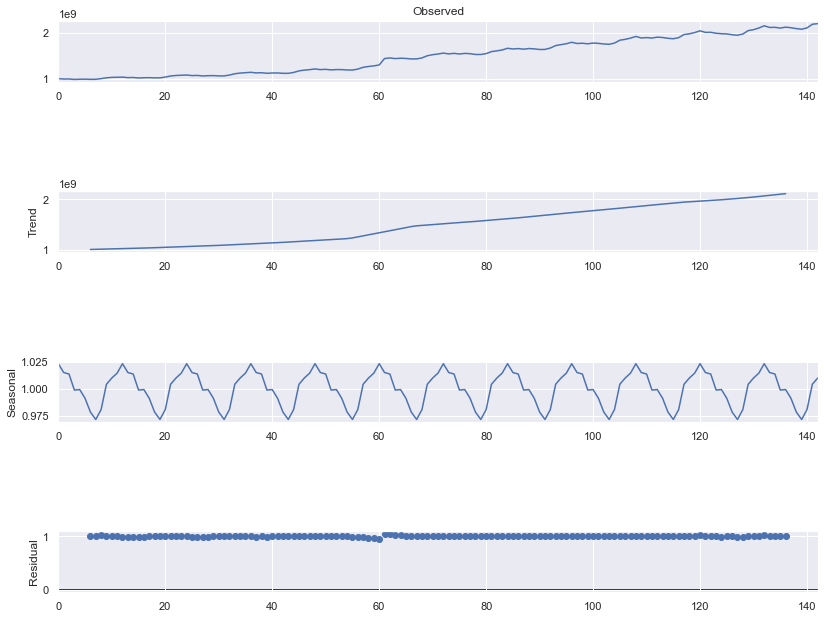

In [301]:
array = np.array(df['vlr'])

results = seasonal_decompose(x=array,model='multiplicative',period=12)

fig = results.plot()
fig.set_size_inches(13, 10)


Os resíduos ficaram bem centrados em 1, o que faz bastante sentido considerando o modelo aditivo

### 1.13 Fazendo a decomposição da série considerando a divisão em produtos para ver o comportamento de cada componente

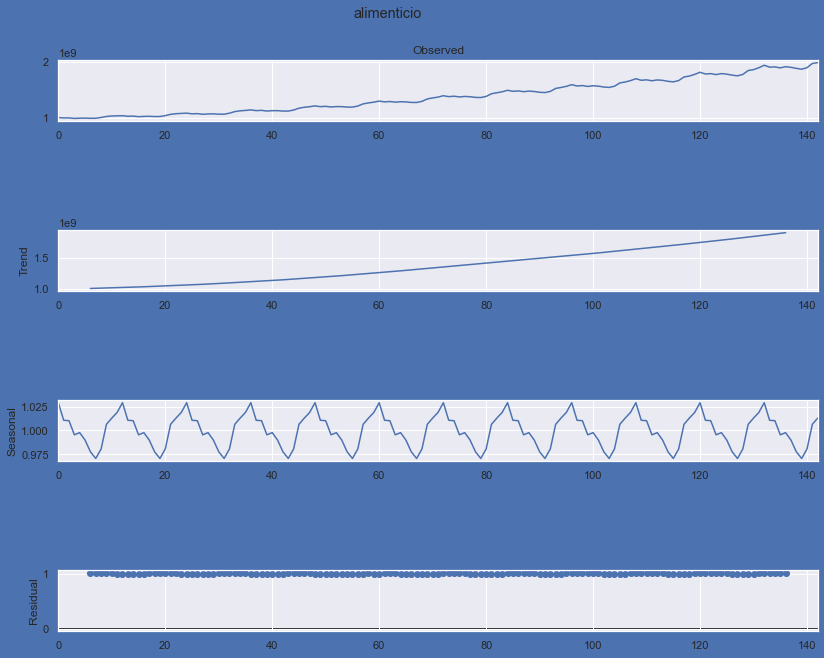

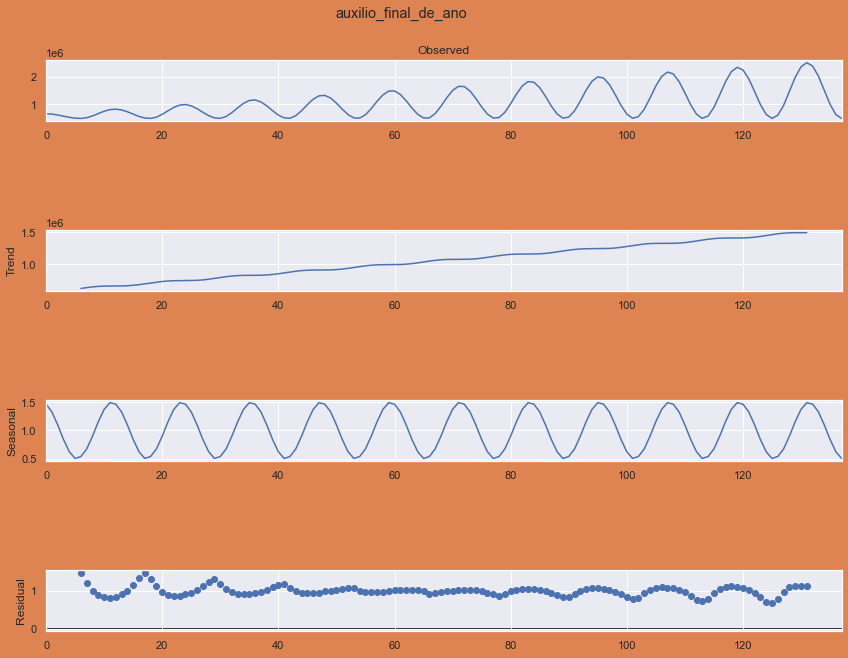

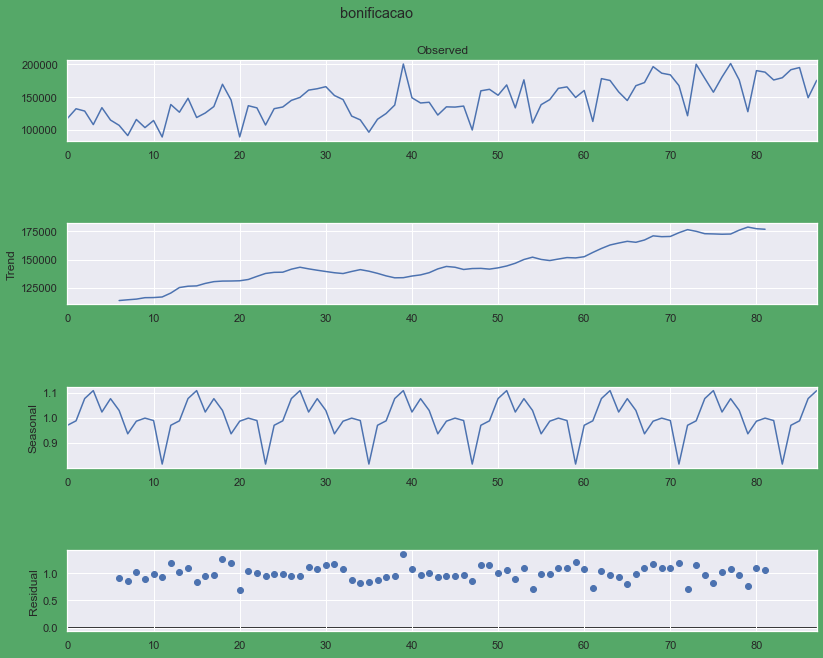

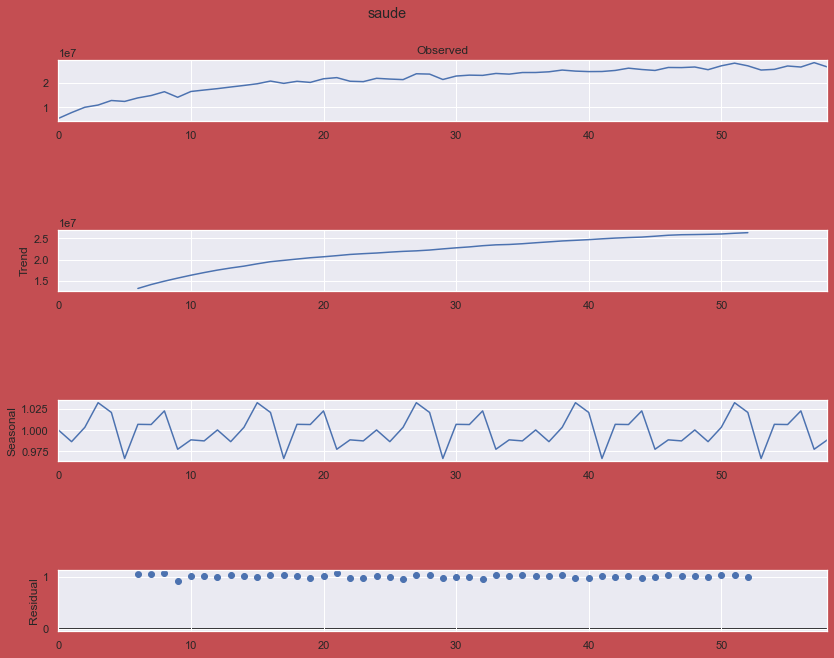

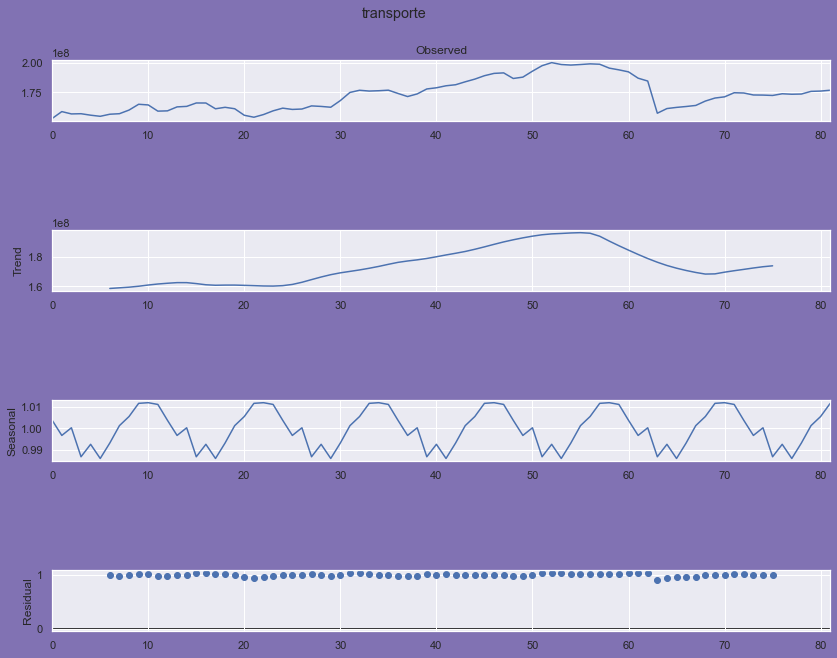

In [302]:
palette = sns.color_palette()


for column,color in zip(df.columns[:-1],palette):
    array = np.array(df[column][df[column]>0])

    results = seasonal_decompose(x=array,model='multiplicative',period=12)

    fig = results.plot()
    fig.set_size_inches(13, 10)
    fig.suptitle(column)
    fig.set_facecolor(color)
    

Aqui novamente o resíduos ficaram bem centrados no 1, indicando que o modelo multiplicativo atende bem

### 1.14 Vamos fazer os gráficos de média móvel de cada coluna do dataset e observar como está a distribuição anual da série e de cada produto

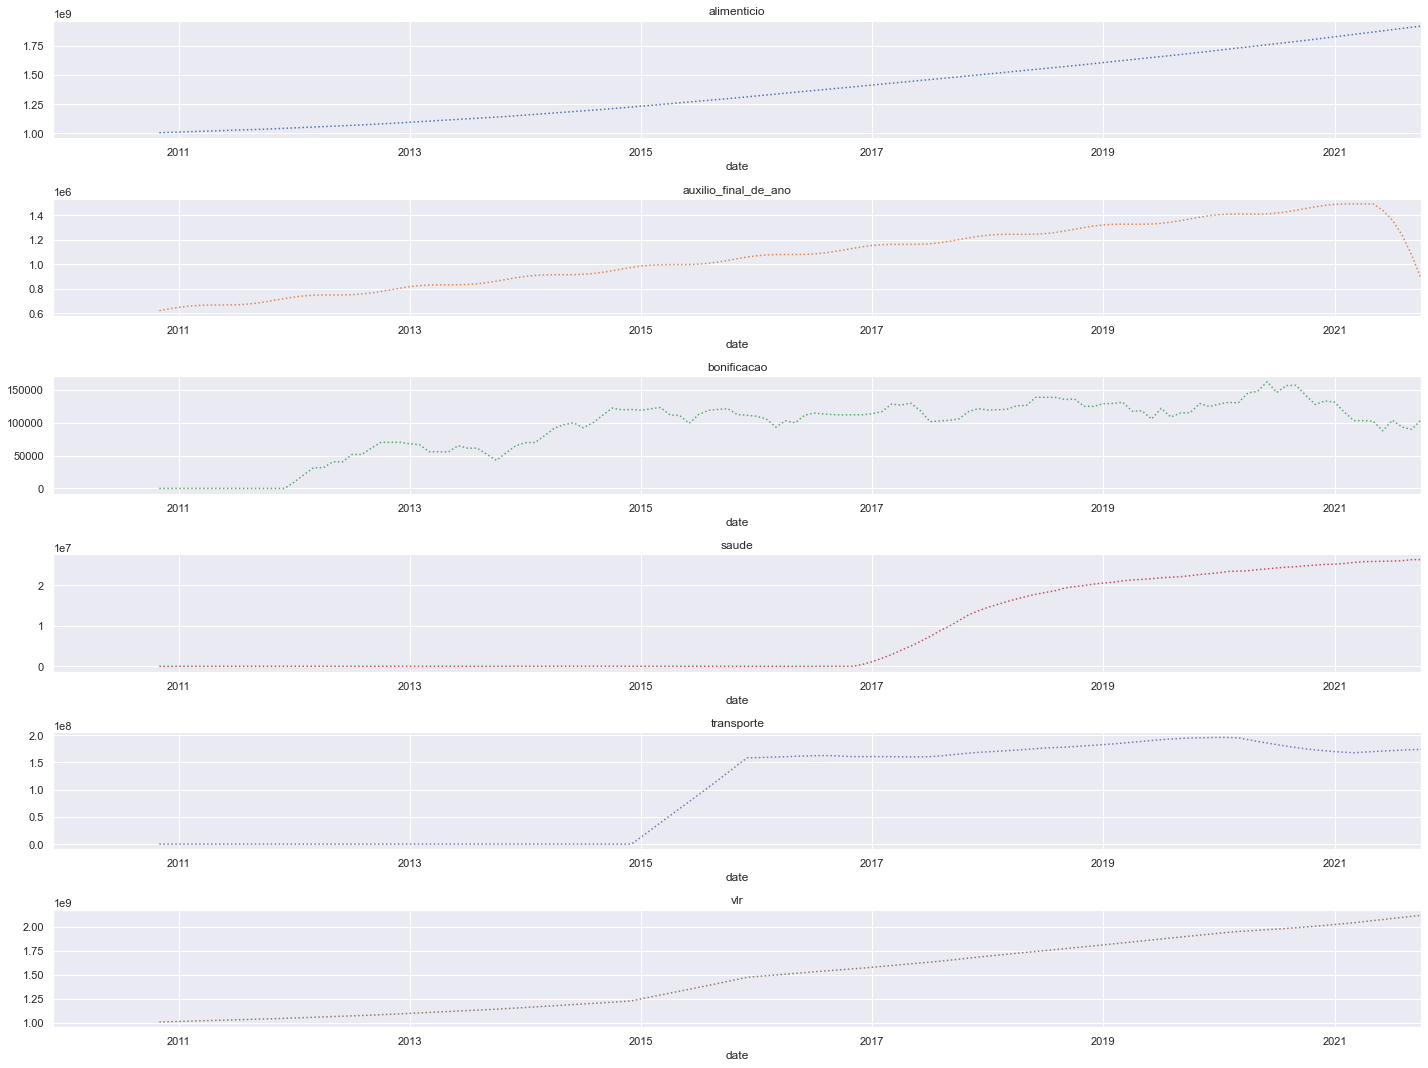

In [303]:
sns.set()
palette = sns.color_palette()
fig, ax = plt.subplots(6,1,figsize=(20,15))
ax = ax.ravel()

for column,color,ax in zip(df.columns,palette,ax):
    
    df[column].rolling(window=12).mean().plot(ax=ax,color=color,ls=':')
    ax.set_title(column)
   

fig.tight_layout()

As distribuições anuais reduziram bastante a variância nos produtos bonificação e auxilio de final de ano, o que faz total sentido já que olhando de forma mensal esses produtos tendem a se concetrar no final do ano e a média móvel anual esse efeito é removido

## 2. Predição usando os valores totais de faturamento (soma de todos os produtos)

### 2.1 Fazendo a curva de correlação ACF

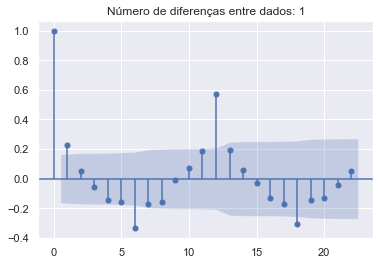

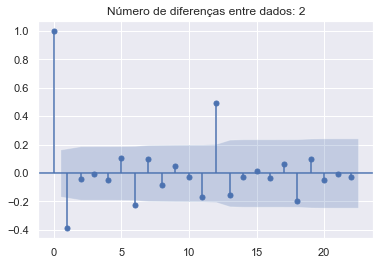

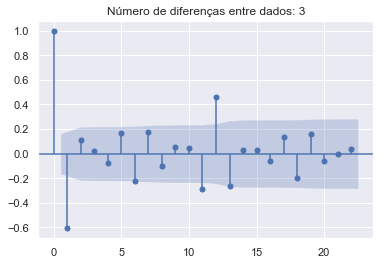

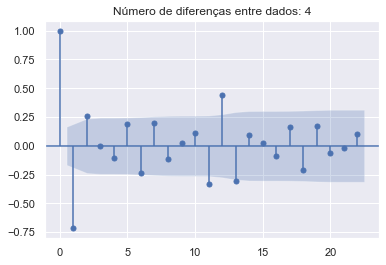

In [304]:
for n in range(1,5):
    plot_acf(np.diff(df['vlr'],n=n));
    plt.title(f'Número de diferenças entre dados: {n}')


A media que o número de diferenças aumenta, vemos que o padrão com o pico em 12 períodos regressivos continua em 12 meses, indicando um forte indício de sazonalidade nesse período. Pelos gráficos acima, também é possível inferir que aumentar o número de diferenças não fará tanta diferença no modelo. Considerando o número de diferenças como 2, vemos um pico mais expressivo fora do intervalo de confiança em 2, indicando uma possível boa métrica para o parâmetro q (MA) quando formos realizar o processo interativo de fit do modelo

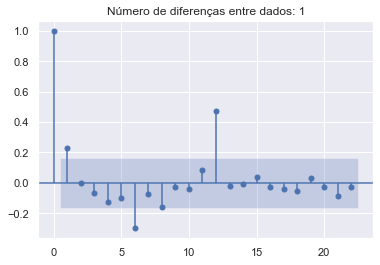

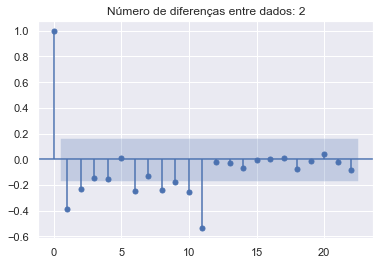

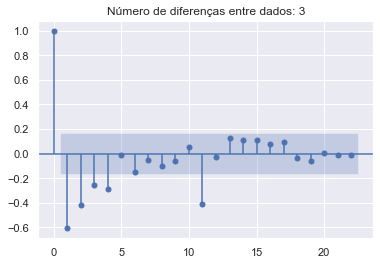

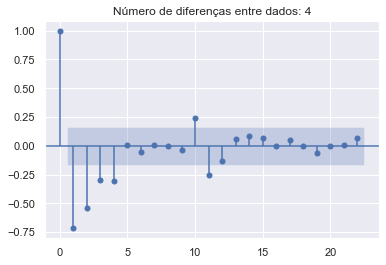

In [305]:
for n in range(1,5):
    plot_pacf(np.diff(df['vlr'],n=n),method='ywm');
    plt.title(f'Número de diferenças entre dados: {n}')

Para o parâmetro p da parte AR (mede a autocorrelação entre o perído atual e o primeiro período q) o número de diferenças tem maior importância, já que temos picos mais acentuados. 

- Para n = 2, q = 2,11 se destacam com parâmetros de maior relevância
- Para n = 3, q = 1,2 parecem ser bons números para usar no modelo interativo
- Para n = 4, q = 1,2 parecem ser bons números para usar no modelo interativo


### 2.2 Separando a base em treino (80%) e teste (20%)

In [306]:
tamanho = len(df['vlr'])
treino_size = ceil(tamanho*0.8)

treino = df['vlr'][:treino_size]
teste = df['vlr'][treino_size:]

### 2.3 Para descobrir a ordem do nosso modelo e qual é o melhor tipo a ser usado (AR,MA,ARMA,ARIMA,SARIMA) vamos fazer um processo interativo para descobrir os coeficientes

In [307]:
# Aplica o Auto Arima
stepwise_fit = auto_arima(df['vlr'], 
                          start_p=0, start_q=0,
                          max_p=6, max_q=6, 
                          m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

# Sumário do Auto Arima
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5221.392, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5219.700, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5221.806, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5221.595, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5235.466, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5219.414, Time=0.08 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=5219.803, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5219.484, Time=0.04 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=5221.774, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5221.374, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5223.337, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=5252.996, Time=0.02 sec

Best model:  ARIMA(0,1,0)(1,0,0)[12] intercept
Total fit time: 0.883 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -2606.707
Date:                            Tue, 23 Nov 2021   AIC                           5219.414
Time:                                    21:18:48   BIC                           5228.281
Sample:                                         0   HQIC                          5223.017
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.355e+06   1.93e-11   4.34e+17      0.000    8.36e+06    8.36e+06
ar.S.L12       0.0331      0.013      2.601      0.009       0.008       0.058
sigma2      5.239e+14   9.63e-20   5.44e+33      0.000    5.24e+14    5.24e+14
===================================================================================
Ljung-Box (L1) (Q):                   7.64   Jarque-Bera (JB):               382.39
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.23e+50. Standard errors may be unstable.
"""

Segundo o processo regressimo o melhor modelo é um SARIMA com as componentes q = 0, p = 0, d = 1, P = 1, Q = 0, D = 0 com a sazonalidade em 12 meses. Vamos treinar um modelo Sarima com esses parâmetros

### 2.4 Treinando o modelo

In [308]:
order = (0,1,0)
seasaonal_order = (1,0,0,12)

smodel = SARIMAX(treino, order = order, seasonal_order = seasaonal_order)
sresults = smodel.fit()
sresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                vlr   No. Observations:                  115
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -2089.379
Date:                            Tue, 23 Nov 2021   AIC                           4182.759
Time:                                    21:18:48   BIC                           4188.231
Sample:                                12-01-2009   HQIC                          4184.980
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0263      0.015      1.707      0.088      -0.004       0.056
sigma2      3.904e+14   4.76e-19    8.2e+32      0.000     3.9e+14     3.9e+14
===================================================================================
Ljung-Box (L1) (Q):                   5.39   Jarque-Bera (JB):               925.21
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                             2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+49. Standard errors may be unstable.
"""

### 2.3 Obtendo as predições

In [309]:

# Definindo onde começa e termina
start = len(treino)
end = len(treino) + len(teste) - 1

# calculando as predições
predicts = sresults.predict(start = start, 
                           end = end, 
                           dynamic = True, 
                           typ='levels').rename('Previsões SARIMA(0,1,0)(1,0,0)[12]')

# Ajustando os indexs
predicts.index = teste.index

### 2.4 Plotando o gráfico dos valores de teste e dos valores preditos

Text(0.5, 1.0, 'Previsões de faturamento total (teste x predito)')

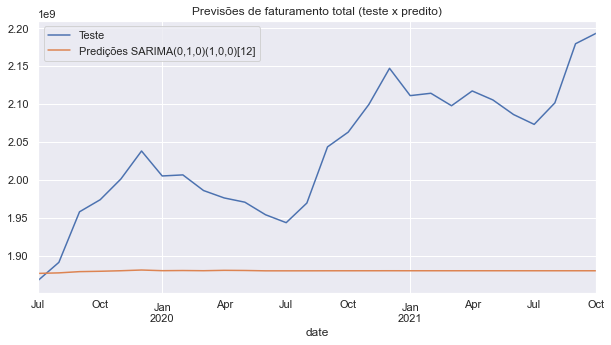

In [310]:
teste.plot(label='Teste',legend=True,figsize=(10,5))
predicts.plot(label='Predições SARIMA(0,1,0)(1,0,0)[12]',legend=True,figsize=(10,5))
plt.title('Previsões de faturamento total (teste x predito)')


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                vlr   No. Observations:                  115
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -2089.379
Date:                            Tue, 23 Nov 2021   AIC                           4182.759
Time:                                    21:18:48   BIC                           4188.231
Sample:                                12-01-2009   HQIC                          4184.980
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0263      0.015      1.707      0.088      -0.004       0.056
sigma2      3.904e+14   4.76e-19    8.2e+32      0.000     3.9e+14     3.9e+14
===================================================================================
Ljung-Box (L1) (Q):                   5.39   Jarque-Bera (JB):               925.21
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                             2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+49. Standard errors may be unstable.
"""

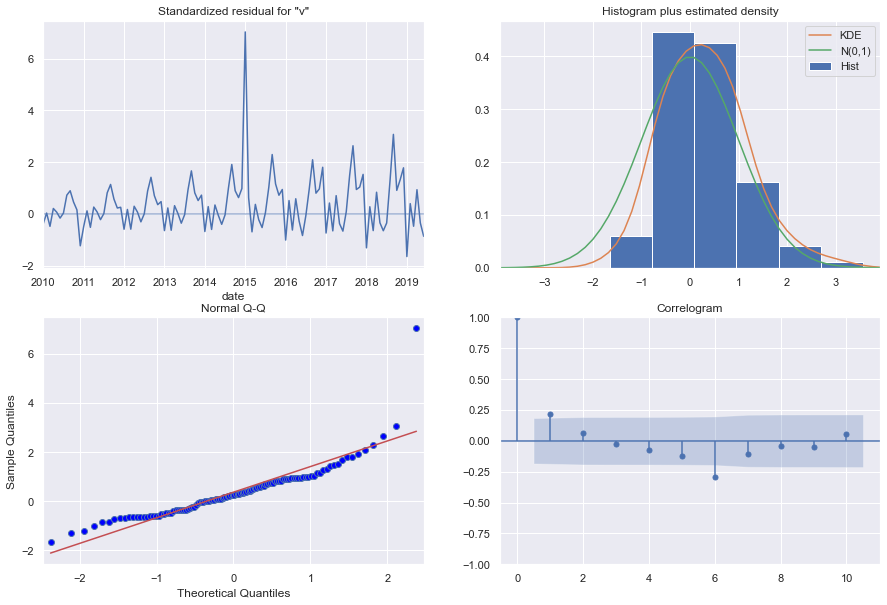

In [311]:
sresults.plot_diagnostics(figsize=(15,10));
sresults.summary()

Aparentemente as previsões ficaram péssimas e olhando para os resíduos eles também ficaram bem elevados

Text(0.5, 1.0, 'Previsões de faturamento total')

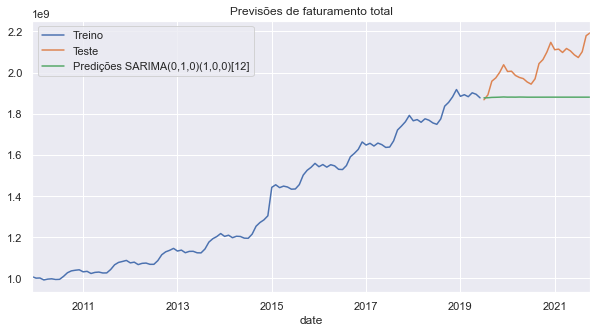

In [312]:
treino.plot(label='Treino',legend=True,figsize=(10,5))
teste.plot(label='Teste',legend=True,figsize=(10,5))
predicts.plot(label='Predições SARIMA(0,1,0)(1,0,0)[12]',legend=True,figsize=(10,5))
plt.title('Previsões de faturamento total')

Pelo gráfico acima, vemos que o modelo falhou totalmente em prever o comportamento da série. Podemos ver que em 2015 tivemos uma mudança abrupta quando a empresa começou a vender o produto transporte que contribui bastante com a receita atualmente. Dessa forma, faremos um corte nos dados e pegaremos somente valores de 2015 para cima

<AxesSubplot:title={'center':'Valor de faturamento com cortes em anos abaixo de 2015'}, xlabel='date'>

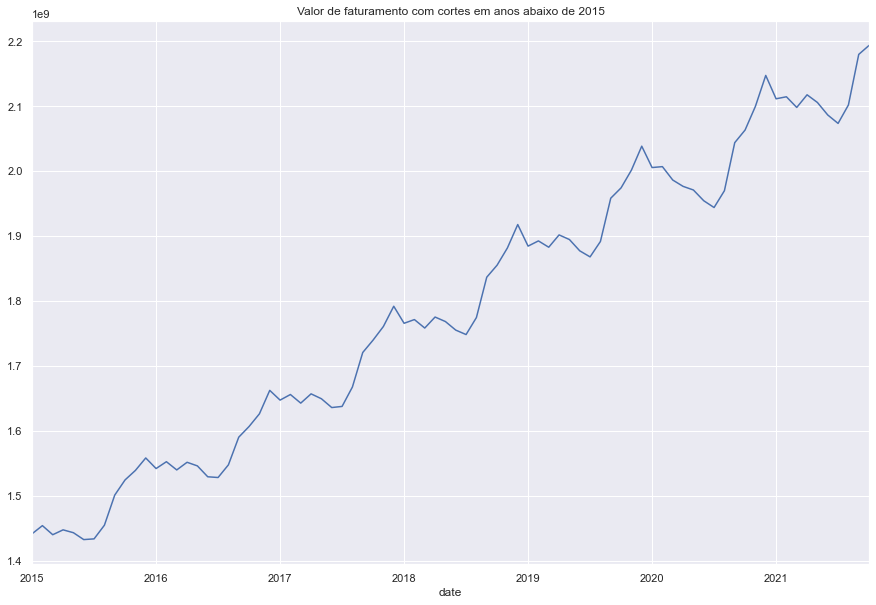

In [313]:
df_cut = df['vlr']['2015-01-01':,]
df_cut.plot(title='Valor de faturamento com cortes em anos abaixo de 2015',figsize=(15,10))

### 2.5 Fazendo o processo interativo novamente

In [314]:
stepwise_fit = auto_arima(df_cut, 
                          start_p=0, start_q=0,
                          max_p=6, max_q=6, 
                          m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2527.407, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11451.081, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2796.372, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2520.496, Time=0.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2520.441, Time=0.09 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=2520.402, Time=0.35 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=2518.425, Time=0.89 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=2520.391, Time=0.22 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=2523.176, Time=0.74 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,0,0)(2,1,2)[12]             : AIC=inf, Time=1.25 sec

Best model:  ARIMA(0,0,0)(2,1,2)[12] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                   82
Model:             SARIMAX(2, 1, [1, 2], 12)   Log Likelihood               -1253.212
Date:                       Tue, 23 Nov 2021   AIC                           2518.425
Time:                               21:18:57   BIC                           2531.916
Sample:                                    0   HQIC                          2523.784
                                        - 82                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.108e+08   6.29e-10   1.76e+17      0.000    1.11e+08    1.11e+08
ar.S.L12       0.4323      0.293      1.475      0.140      -0.142       1.007
ar.S.L24      -0.4257      0.277     -1.534      0.125      -0.970       0.118
ma.S.L12      -0.4440      0.291     -1.527      0.127      -1.014       0.126
ma.S.L24       0.4346      0.278      1.561      0.118      -0.111       0.980
sigma2       2.65e+14   1.44e-15   1.84e+29      0.000    2.65e+14    2.65e+14
===================================================================================
Ljung-Box (L1) (Q):                  52.01   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               4.75   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+46. Standard errors may be unstable.
"""

O AIC caiu drasticamente, indicando que pode o corte da série dos anos menores que 2015 foi eficiente para o modelo Sarima prever o comportamento da série temporal. Agora o melhor modelo encontrado foi um SARIMA(0,0,0)(2,1,2)[12]. Apesar disso, alguns parametros ainda apresentam p valores altos, sendo pouco relevantes para o modelo

### 2.6 Treinando o modelo novamente e obtendo as predições. Porém como são menos observações faremos uma divisão de 70% treino e 30% teste

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                   SARIMAX Results                                   
Dep. Variable:                           vlr   No. Observations:                   58
Model:             SARIMAX(2, 1, [1, 2], 12)   Log Likelihood                -811.777
Date:                       Tue, 23 Nov 2021   AIC                           1633.554
Time:                               21:18:57   BIC                           1642.697
Sample:                           01-01-2015   HQIC                          1636.979
                                - 10-01-2019                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0167      0.194      0.086      0.931      -0.363       0.397
ar.S.L24       0.9826      0.215      4.576      0.000       0.562       1.

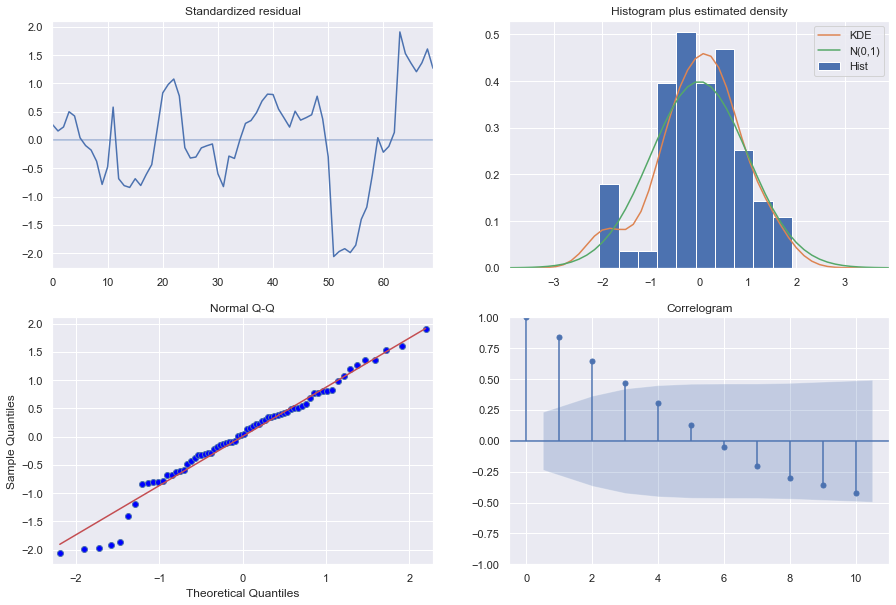

In [315]:
tamanho = len(df_cut)
treino_size = ceil(tamanho*0.7)

treino = df_cut[:treino_size]
teste = df_cut[treino_size:]

order= (0,0,0)
seasaonal_order = (2,1,2,12)

smodel = SARIMAX(treino, order = order, seasonal_order = seasaonal_order)
sresults = smodel.fit()
print(sresults.summary())



# Definindo onde começa e termina
start = len(treino)
end = len(treino) + len(teste) - 1

# calculando as predições
predicts = sresults.predict(start = start, 
                        end = end, 
                        dynamic = True, 
                        typ='levels').rename(f'Previsões SARIMA{order} {seasaonal_order}')

# Ajustando os indexs
predicts.index = teste.index

stepwise_fit.plot_diagnostics(figsize=(15,10));


Tiveremos uma melhoria de 60%  no AIC indo de 4182.759 para 1633.554

### 2.7 Plotando o gráfico dos valores de teste e dos valores preditos

Text(0.5, 1.0, 'Previsões de faturamento total')

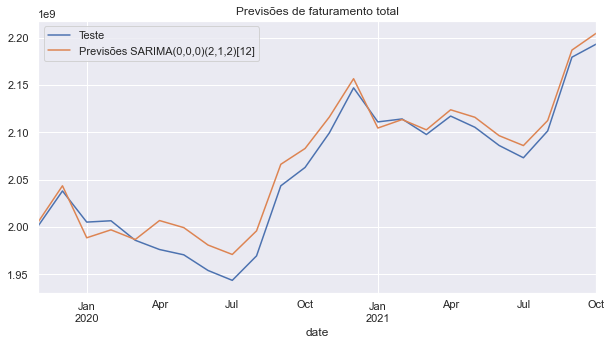

In [316]:
teste.plot(label='Teste',legend=True,figsize=(10,5))
predicts.plot(label='Previsões SARIMA(0,0,0)(2,1,2)[12]',legend=True,figsize=(10,5))
plt.title('Previsões de faturamento total')

Claramente o modelo está conseguindo capturar muito melhor o comportamento da curva agora

Text(0.5, 1.0, 'Previsões de faturamento total')

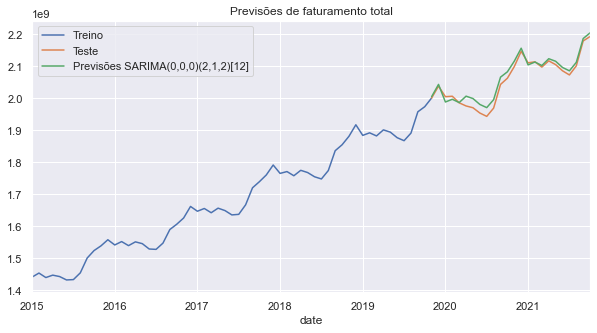

In [317]:
df_cut[:(treino_size+1)].plot(label='Treino',legend=True,figsize=(10,5)) #coloquei dessa forma somente para a pontinha do gráfico não ficar cortada (entre treino e teste)
teste.plot(label='Teste',legend=True,figsize=(10,5))
predicts.plot(label='Previsões SARIMA(0,0,0)(2,1,2)[12]',legend=True,figsize=(10,5))
plt.title('Previsões de faturamento total')

### 2.8 Vamos prever o faturamento dos meses de nov e dezembro de 2021 e para o ano de 2022 todo

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Volume de vendas total')

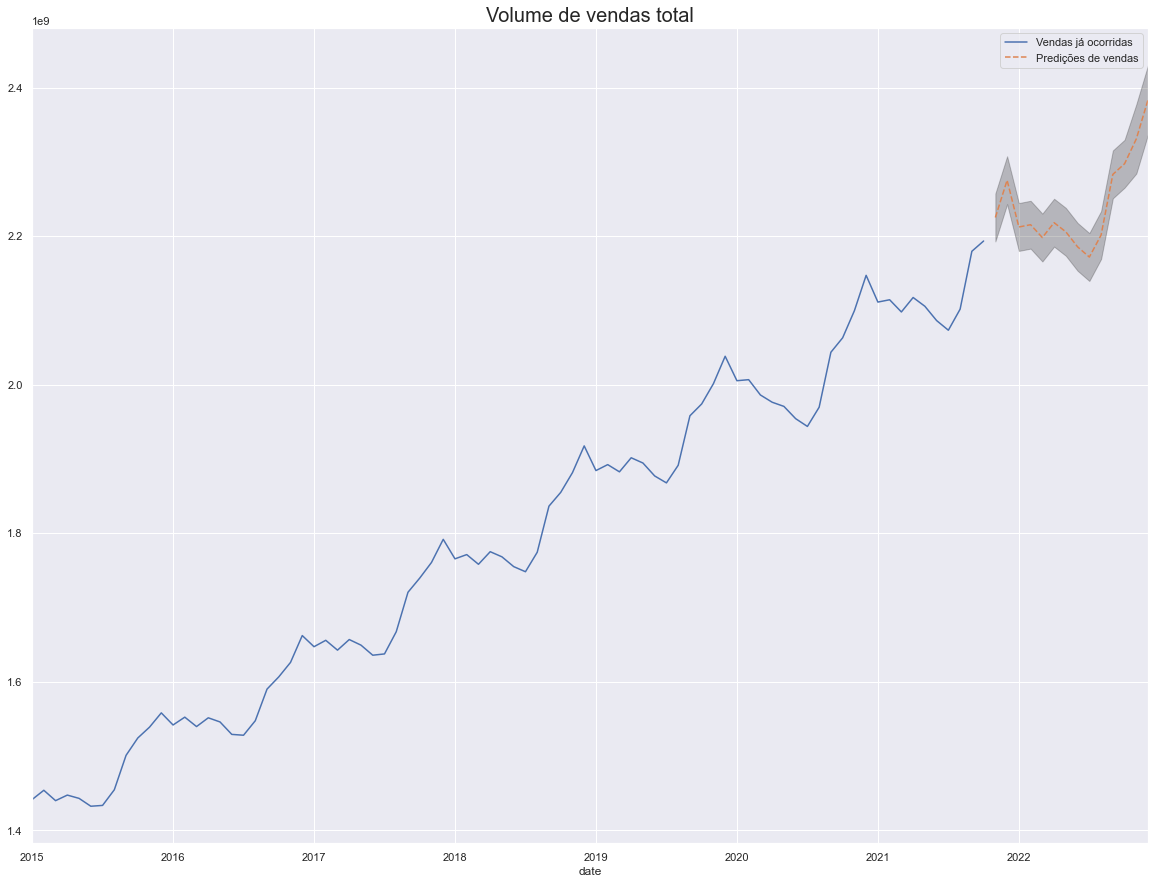

In [318]:
periods = 14 #meses para prever nov,dez/21 e 2022 inteiro

order= (0,0,0)
seasaonal_order = (2,1,2,12)

smodel = SARIMAX(df_cut, order = order, seasonal_order = seasaonal_order)
sresults = smodel.fit()

predictions = sresults.get_forecast(steps = periods)
ic = predictions.conf_int()

ax = df_cut.plot(label='Vendas já ocorridas',figsize=(20,15))
predictions.predicted_mean.plot(label='Predições de vendas',ax=ax,ls='--')
ax.fill_between(ic.index,
                ic.iloc[:, 0],
                ic.iloc[:, 1], color='k', alpha=.25);

ax.legend()
ax.set_title('Volume de vendas total',fontsize=20)

Vamos agora realizar o mesmo procedimento para cada produto e com as predições indiduais comparar com a predição a partir do total

## 3. Predição do total faturado para o final de 2021 e 2022 usando a soma das predições dos faturamentos de cada produto

### 3.1 Replotando a curva de cada produto para relembrar como estão

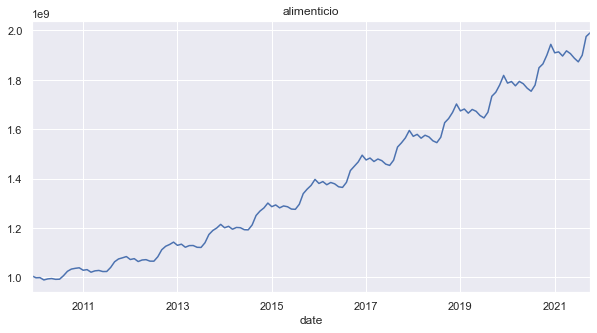

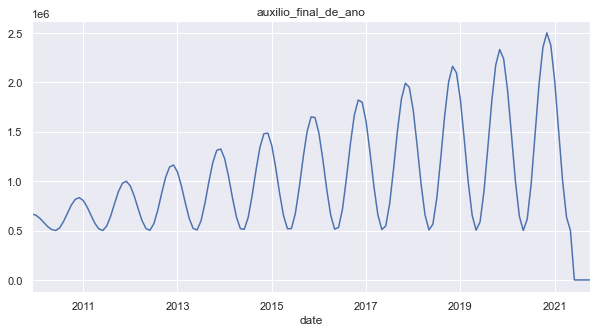

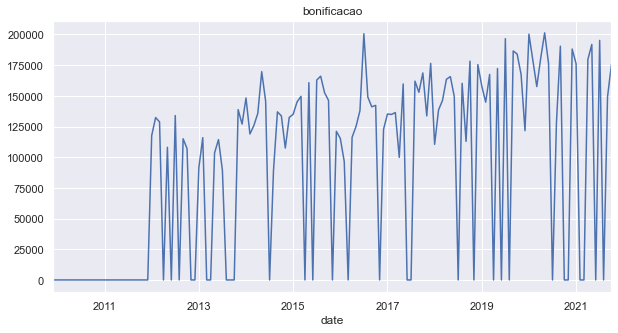

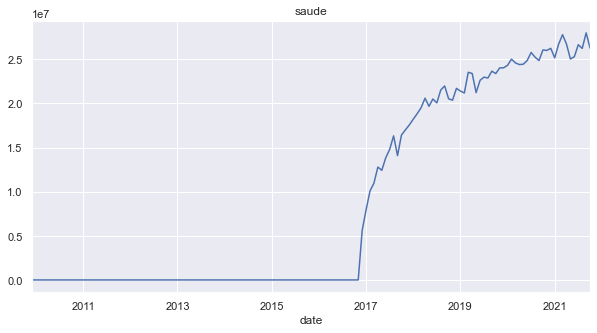

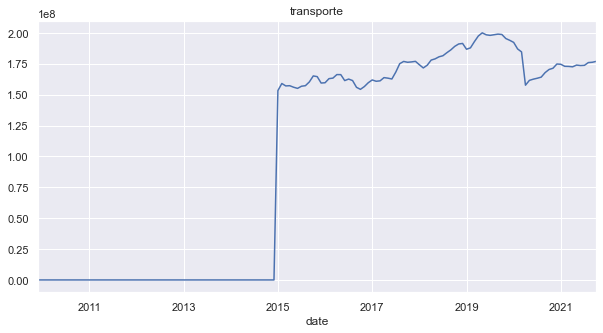

In [319]:
for column in df.columns[:-1]:
    df[column].plot(figsize=(10,5),label=column)
    plt.title(column)
    plt.show()

Pelas curvas acima vemos que talvez tenhamos que fazer alguns cortes ou adequações nas séries pelos seguintes motivos:

- alimentício: após 2015 o padrão de variação da curva fica muito mais acentuado
- Saude: próximo do final de 2018 tem um pico bem acentuado que pode prejudicar nossa predição
- transporte: em 2020, provavelmente em função do corona vírus teve uma queda acentuada e isso também poderá prejudicar nossa predição

### 3.2 Obtendo o melhor modelo considernado todo o intervalo de data em todos os produtos e sazonalidade anual

In [320]:
dicio_autoarima = {}

for coluna in df.columns[:-1]:
    stepwise_fit = auto_arima(df[coluna], 
                            start_p=0, start_q=0,
                            max_p=6, max_q=6, 
                            m=12,
                            seasonal=True,
                            trace=True,
                            error_action='ignore',   
                            suppress_warnings=True,  
                            stepwise=True)
    dicio_autoarima[coluna] = (stepwise_fit.order,stepwise_fit.seasonal_order)

print(dicio_autoarima)       

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5758.501, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4212.019, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4213.815, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5752.270, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4212.465, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4212.444, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4214.853, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=4203.234, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=4204.913, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=4206.904, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=4203.659, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept

Tivemos os seguintes resultados: para cada produto

- 'alimenticio': SARIMA ((0, 1, 0), (0, 1, 0, 12))
- 'auxilio_final_de_ano': SARIMA((1, 0, 1), (0, 1, 0, 12))
- 'bonificacao': SARIMA ((0, 1, 1), (0, 0, 0, 12))
- 'saude': SARIMA ((0, 1, 0), (0, 0, 0, 12))
- 'transporte': SARIMA ((0, 1, 0), (0, 0, 0, 12))}



### 3.3 Agora treinaremos cada modelo e faremos o predict usando a base de treino de cada produto

In [321]:
dicio_models = {}

for coluna in df.columns[:-1]:

    df_for = df[coluna][df[coluna]>0] #tirando os valores menores que zero de todas as séries

    #após os plots perceberemos que tirar os valores nulos também prejudicam bastante algumas séries já que também removem a sazonalidade

    tamanho = len(df_for)
    treino_size = ceil(tamanho*0.8)

    treino = df_for[:treino_size]
    teste = df_for[treino_size:]

    order= dicio_autoarima[coluna][0]
    seasaonal_order = dicio_autoarima[coluna][1]

    smodel = SARIMAX(treino, order = order, seasonal_order = seasaonal_order)
    sresults = smodel.fit()


    # Definindo onde começa e termina
    start = len(treino)
    end = len(treino) + len(teste) - 1

    # calculando as predições
    predicts = sresults.predict(start = start, 
                            end = end, 
                            dynamic = True, 
                            typ='levels').rename(f'Previsões SARIMA {coluna} {order} {seasaonal_order}')

    # Ajustando os indexs
    predicts.index = teste.index

    dicio_models[coluna] = (sresults,predicts,df_for,treino,teste)

    print(coluna,sresults.aic)

alimenticio 3290.9394677988084
auxilio_final_de_ano 2874.591463417031
bonificacao 1613.7135626306617
saude 1444.2259442731333
transporte 2173.3969515181734


C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at

Temos os seguintes AIC para cada modelo
- alimenticio 3290.9394677988084
- auxilio_final_de_ano 2874.591463417031
- bonificacao 1613.7135626306617
- saude 1444.2259442731333
- transporte 2173.3969515181734

### 3.4 Vamos agora os gráficos dos valores preditos vs os valores de teste

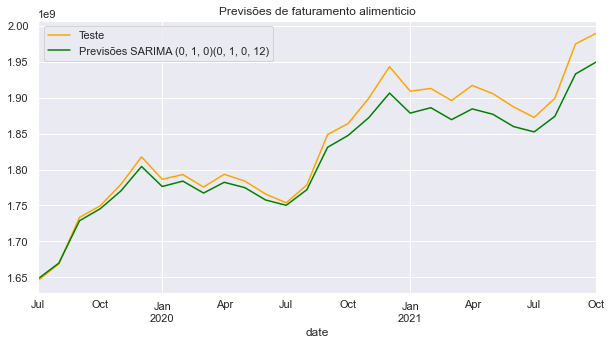

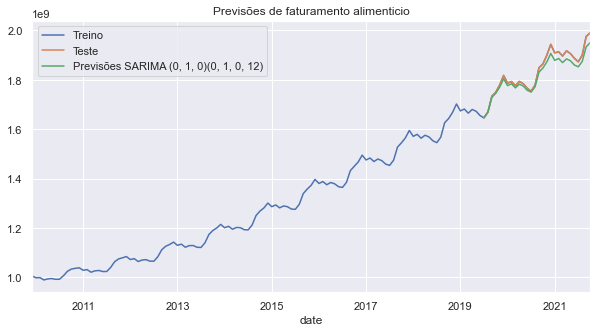

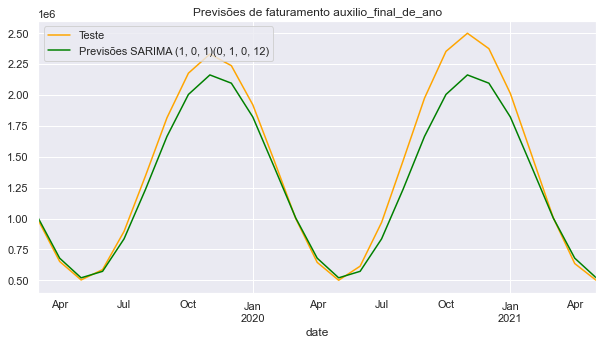

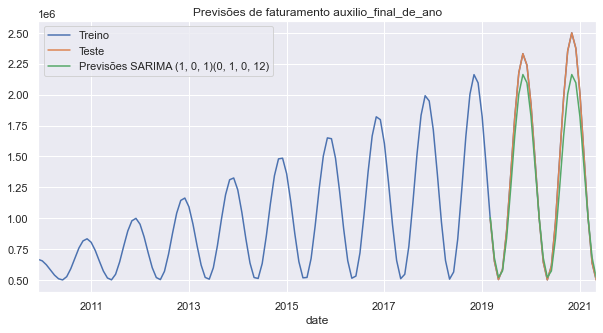

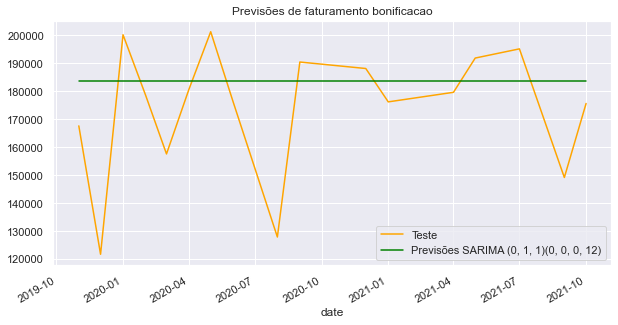

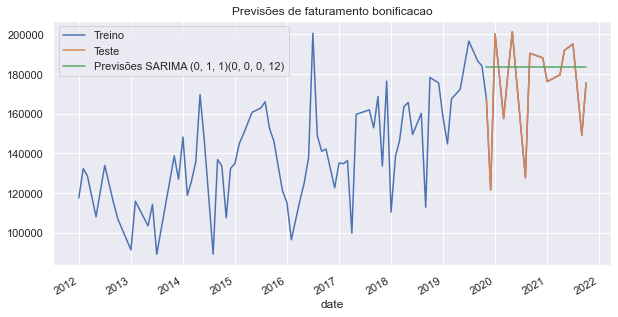

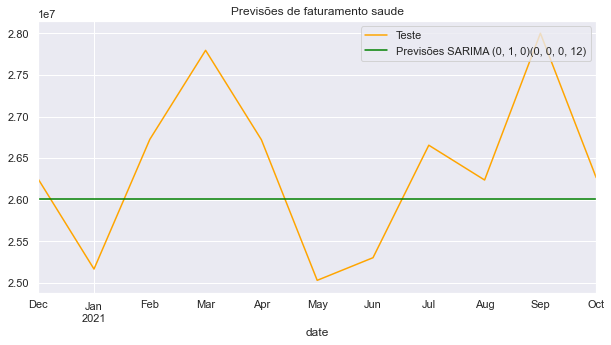

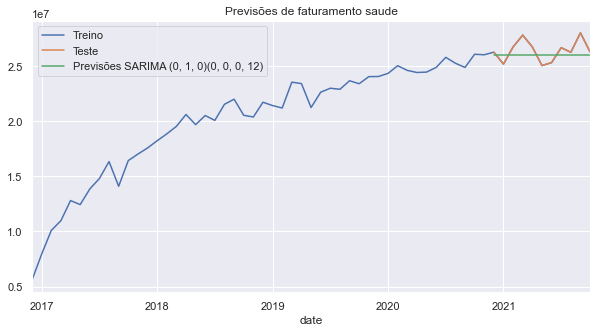

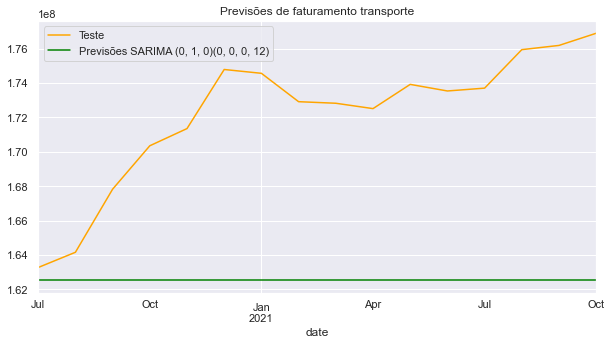

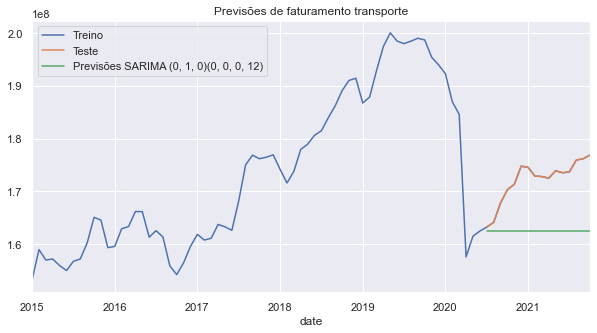

In [322]:

for coluna in df.columns[:-1]:
    
    #posição 4 tem a base de teste
    dicio_models[coluna][4].plot(label='Teste',legend=True,figsize=(10,5),c='orange')
    
    #posição 1 tem os valores preditos
    dicio_models[coluna][1].plot(label=f'Previsões SARIMA {dicio_autoarima[coluna][0]}{dicio_autoarima[coluna][1]}',legend=True,figsize=(10,5),color='green')
    plt.title(f'Previsões de faturamento {coluna}')
    plt.show()

    
    #plota base de treino
    dicio_models[coluna][2].plot(label='Treino',legend=True,figsize=(10,5))
    #plota base de teste
    dicio_models[coluna][4].plot(label='Teste',legend=True,figsize=(10,5))

     #plota os valores preditos
    dicio_models[coluna][1].plot(label=f'Previsões SARIMA {dicio_autoarima[coluna][0]}{dicio_autoarima[coluna][1]}',legend=True,figsize=(10,5))
    plt.title(f'Previsões de faturamento {coluna}')
    plt.show()

O fit para os produtos alimentícios e para a auxilio de final de ano ficaram interessantes e podem ser melhorados escolhendo um intervalo de tempo diferente. 

Já o fit para os outros 3 produtos não funcionou com o intervalo de todo o período. Os modelos não conseguiram captar o comportamento da curva e para eles teremos que escolher um modelo diferente, um período de tempo diferente ou usar alguma outra estratégia para captar melhor o comportamento dos dados. 

### 3.5 Fazendo o ajuste fino nos modelos alimentícios e auxilio de final de ano

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2247.592, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2248.808, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2248.926, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3239.008, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2247.867, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2248.480, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2248.536, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2250.468, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=2246.614, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=2246.452, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2243.863, Time=0.24 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=2236.957, Time=0.95 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=2239.763, Time=0.26 sec
 ARIMA(0,1,0)(2,1,2)[12]

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


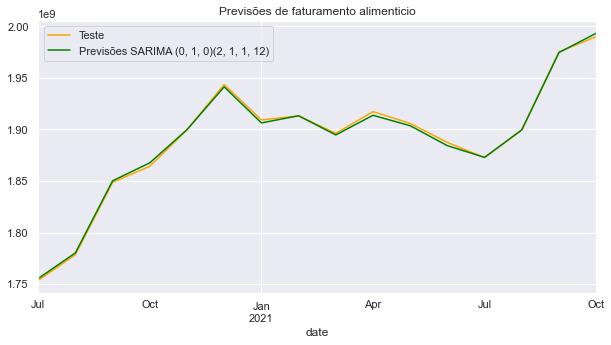

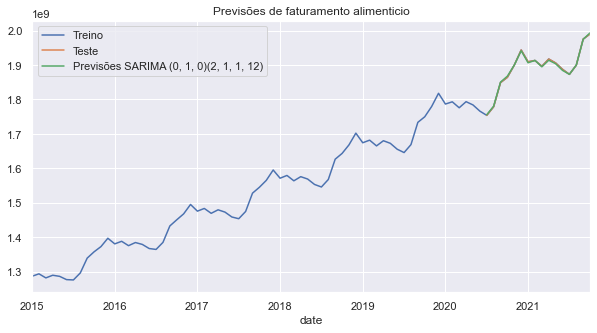

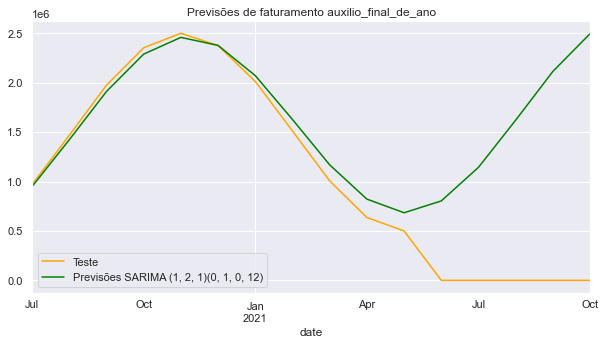

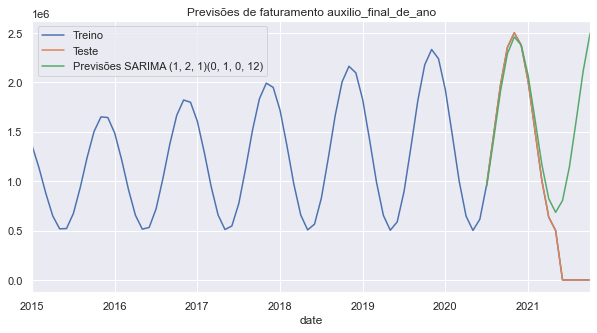

In [323]:
#Vamos pegar ambos a partir do ano de 2015

dicio_autoarima_tunning = {}

#Fazendo o auto arima
for coluna in df.columns[0:2]:
    stepwise_fit = auto_arima(df[coluna]['2015-01-01':,], 
                            start_p=0, start_q=0,
                            max_p=6, max_q=6, 
                            m=12,
                            seasonal=True,
                            trace=True,
                            error_action='ignore',   
                            suppress_warnings=True,  
                            stepwise=True)
    dicio_autoarima_tunning[coluna] = (stepwise_fit.order,stepwise_fit.seasonal_order) 

print(dicio_autoarima_tunning)


#Fazendo o fit e predict
dicio_models_tunning = {}

for coluna in df.columns[0:2]:

    df_for = df[coluna]['2015-01-01':,]

    tamanho = len(df_for)
    treino_size = ceil(tamanho*0.8) #80% de treino e 20% de teste

    treino = df_for[:treino_size]
    teste = df_for[treino_size:]

    order= dicio_autoarima_tunning[coluna][0]
    seasaonal_order = dicio_autoarima_tunning[coluna][1]

    smodel = SARIMAX(treino, order = order, seasonal_order = seasaonal_order)
    sresults = smodel.fit()
    


    # Definindo onde começa e termina
    start = len(treino)
    end = len(treino) + len(teste) - 1

    # calculando as predições
    predicts = sresults.predict(start = start, 
                            end = end, 
                            dynamic = True, 
                            typ='levels').rename(f'Previsões SARIMA {coluna} {order} {seasaonal_order}')

    # Ajustando os indexs
    predicts.index = teste.index

    # Fazendo o fit final para depois prever os 14 meses até o final de 2022
    smodel_final = SARIMAX(df_for, order = order, seasonal_order = seasaonal_order)
    sresults_final = smodel_final.fit()

    dicio_models_tunning[coluna] = (sresults,predicts,df_for,treino,teste,sresults_final)

# Finalzamente fazendo os gráficos 
for coluna in df.columns[0:2]:
    #posição 4 tem a base de teste
    dicio_models_tunning[coluna][4].plot(label='Teste',legend=True,figsize=(10,5),c='orange')
    #posição 1 tem os valores preditos
    dicio_models_tunning[coluna][1].plot(label=f'Previsões SARIMA {dicio_autoarima_tunning[coluna][0]}{dicio_autoarima_tunning[coluna][1]}',legend=True,figsize=(10,5),color='green')
    plt.title(f'Previsões de faturamento {coluna}')
    plt.show()

    #posição 2 tem a base de treino
    dicio_models_tunning[coluna][2].plot(label='Treino',legend=True,figsize=(10,5)) #coloquei dessa forma somente para a pontinha do gráfico não ficar cortada (entre treino e teste)
    dicio_models_tunning[coluna][4].plot(label='Teste',legend=True,figsize=(10,5))
    dicio_models_tunning[coluna][1].plot(label=f'Previsões SARIMA {dicio_autoarima_tunning[coluna][0]}{dicio_autoarima_tunning[coluna][1]}',legend=True,figsize=(10,5))
    plt.title(f'Previsões de faturamento {coluna}')
    plt.show()


Esses foram os novos melhores podemos escolhidos
- 'alimenticio': SARIMA ((0, 1, 0), (2, 1, 1, 12)) -> Adição de 2 parâmetros de auto regressívos sazonal e 1 parâmetro de média móvel sazonal
- 'auxilio_final_de_ano': SARIMA ((1, 2, 1), (0, 1, 0, 12))} -> Adição de 2 parâmetros de diferenciação

In [324]:
print('AIC após o tunning: ',dicio_models_tunning['alimenticio'][0].aic)
print('AIC antes o tunning',dicio_models['alimenticio'][0].aic)

AIC após o tunning:  1819.050649209351
AIC antes o tunning 3290.9394677988084


Claramente o produto alimentício com o corte da série em 2015 e com o uso dos novos parametros do modelo conseguiu capturar melhor o comportamento da curva já que reduziu o AIC em 45%

O produto 'auxilio de final de ano' não está muito claro graficamente se piorou ou melhorou, então vamos olhar para o AIC de cada modelo e ver qual é melhor

In [325]:
print('AIC após o tunning: ',dicio_models_tunning['auxilio_final_de_ano'][0].aic)
print('AIC antes o tunning',dicio_models['auxilio_final_de_ano'][0].aic)

AIC após o tunning:  1166.471263904678
AIC antes o tunning 2874.591463417031


Usando o modelo com os dados após 2015 tivemos uma melhora no AIC de 60%

### 3.6 Fazendo o ajuste fino no modelo de bonificação

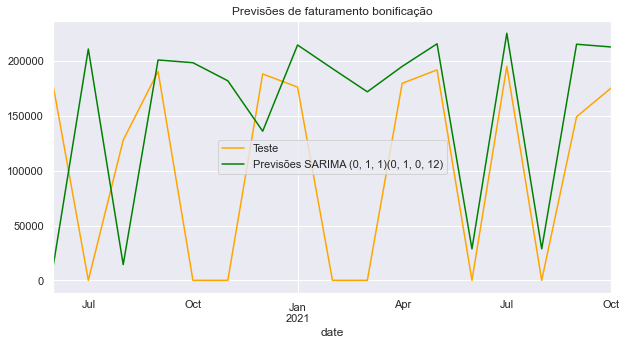

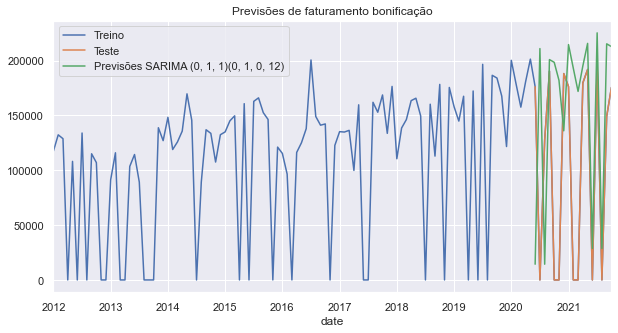

In [326]:
#Vamos tentar aumentar o número de diferenças sazonais para reduzir a variância e pegar somente os valores a partir de 2012


df_for = df['bonificacao']['2012-01-01':] #não vamos mais só considerar os valores positivos porque essa série tem muitos valores negativos no meio que fazem parte da sazonalidade
tamanho = len(df_for)
treino_size = ceil(tamanho*0.85)

treino = df_for[:treino_size]
teste = df_for[treino_size:]

order= (0,1,1) 
seasaonal_order = (0,1,0,12) #aumentando a ordem das diferenças sozonais em 1 unidade

smodel = SARIMAX(treino, order = order, seasonal_order = seasaonal_order)
sresults = smodel.fit()



# Definindo onde começa e termina
start = len(treino)
end = len(treino) + len(teste) - 1

# calculando as predições
predicts = sresults.predict(start = start, 
                        end = end, 
                        dynamic = True, 
                        typ='levels').rename(f'Previsões SARIMA bonificação {order} {seasaonal_order}')

# Ajustando os indexs
predicts.index = teste.index

# Fazendo o fit final para depois prever os 14 meses até o final de 2022

smodel_final = SARIMAX(df_for, order = order, seasonal_order = seasaonal_order)
sresults_final = smodel_final.fit()

dicio_models_tunning['bonificacao'] = (sresults,predicts,df_for,treino,teste,sresults_final)


# Finalzamente fazendo os gráficos 

#posição 4 tem a base de teste
dicio_models_tunning['bonificacao'][4].plot(label='Teste',legend=True,figsize=(10,5),c='orange')
#posição 1 tem os valores preditos
dicio_models_tunning['bonificacao'][1].plot(label=f'Previsões SARIMA {order}{seasaonal_order}',legend=True,figsize=(10,5),color='green')
plt.title(f'Previsões de faturamento bonificação')
plt.show()

#posição 2 tem a base de treino
dicio_models_tunning['bonificacao'][2].plot(label='Treino',legend=True,figsize=(10,5)) #coloquei dessa forma somente para a pontinha do gráfico não ficar cortada (entre treino e teste)
dicio_models_tunning['bonificacao'][4].plot(label='Teste',legend=True,figsize=(10,5))
dicio_models_tunning['bonificacao'][1].plot(label=f'Previsões SARIMA {order}{seasaonal_order}',legend=True,figsize=(10,5))
plt.title(f'Previsões de faturamento bonificação')
plt.show()


Melhor modelo SARIMA (0,1,1)(0,1,0,12)

In [327]:
print('AIC após o tunning: ',dicio_models_tunning['bonificacao'][0].aic)
print('AIC antes o tunning',dicio_models['bonificacao'][0].aic)

AIC após o tunning:  2265.9000808849387
AIC antes o tunning 1613.7135626306617


Na série de bonificação o tunning do modelo teve uma piora no AIC. Poderão ser usadas outras estratégias para reduzir a variância da série como aplicar o log, exp, média móvel ou usar um período de tempo diferente, por exemplo trimestres e prever melhor o comportamento. Essas transformações ficarão como um exercício para melhorar esse projeto

### 3.7 Fazendo o ajuste fino no modelo de saude

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1766.844, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1756.714, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1734.400, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1764.976, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1736.048, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1745.631, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1734.273, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1736.237, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1742.036, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1754.971, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.399 seconds


C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


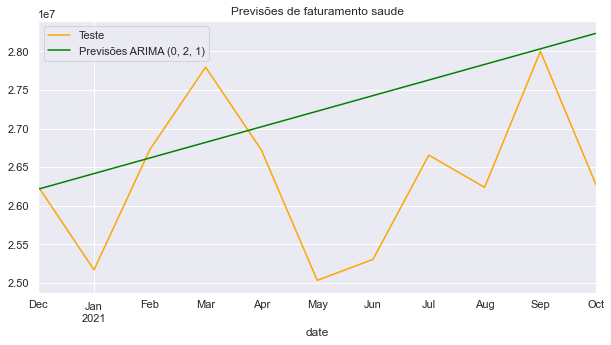

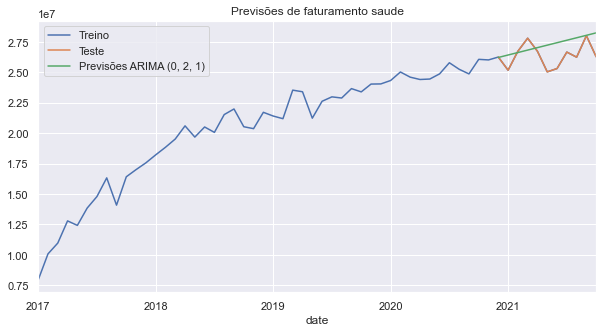

In [328]:
#Aqui usaremos o modelo Arima porque é uma curva sem sazonalidade


df_for = df['saude']['2017-01-01':] #Faremos o corte em 2017 porque porque a partir dessa data não haviam dados
tamanho = len(df_for)
treino_size = ceil(tamanho*0.8)
treino = df_for[:treino_size]
teste = df_for[treino_size:]


stepwise_fit = auto_arima(df['saude']['2017-01-01':,], 
                            start_p=0, start_q=0,
                            max_p=6, max_q=6, 
                            seasonal=False,
                            trace=True,
                            error_action='ignore',   
                            suppress_warnings=True,  
                            stepwise=True)


order= stepwise_fit.order
smodel = ARIMA(treino, order = order)
sresults = smodel.fit()


# Definindo onde começa e termina
start = len(treino)
end = len(treino) + len(teste) - 1

# calculando as predições
predicts = sresults.predict(start = start, 
                        end = end, 
                        dynamic = True, 
                        typ='levels').rename(f'Previsões ARIMA saude {order}')

# Ajustando os indexs
predicts.index = teste.index

# Fazendo o fit final para depois prever os 14 meses até o final de 2022

smodel_final = ARIMA(df_for, order = order)
sresults_final = smodel_final.fit()

dicio_models_tunning['saude'] = (sresults,predicts,df_for,treino,teste,sresults_final)


# Finalzamente fazendo os gráficos 

#posição 4 tem a base de teste
dicio_models_tunning['saude'][4].plot(label='Teste',legend=True,figsize=(10,5),c='orange')
#posição 1 tem os valores preditos
dicio_models_tunning['saude'][1].plot(label=f'Previsões ARIMA {order}',legend=True,figsize=(10,5),color='green')
plt.title(f'Previsões de faturamento saude')
plt.show()

#posição 2 tem a base de treino
dicio_models_tunning['saude'][2].plot(label='Treino',legend=True,figsize=(10,5)) #coloquei dessa forma somente para a pontinha do gráfico não ficar cortada (entre treino e teste)
dicio_models_tunning['saude'][4].plot(label='Teste',legend=True,figsize=(10,5))
dicio_models_tunning['saude'][1].plot(label=f'Previsões ARIMA {order}',legend=True,figsize=(10,5))
plt.title(f'Previsões de faturamento saude')
plt.show()

Melhor modelo ARIMA(0,2,1)

In [329]:
print('AIC após o tunning: ',dicio_models_tunning['saude'][0].aic)
print('AIC antes o tunning',dicio_models['saude'][0].aic)

AIC após o tunning:  1395.1942604237981
AIC antes o tunning 1444.2259442731333


Agora que removemos a sazonalidade e usamos um modelo ARIMA ao invés de um modelo SARIMA, nosso modelo consegue captar um pouco melhor o comportamento da curva. É possível ver pelo gráfico que em alguns anos do produto saúde tiveram ocscilações de faturamento (positivas e negativas) em alguns meses mas no geral o produto apresenta uma tendência crescente

### 3.8 Fazendo o ajuste fino no modelo de transporte

Primeiramente vamos ver em que mês de 2020 a curva cai drasticamente porque usaremos os dados somente a partir desse mês

<AxesSubplot:xlabel='date'>

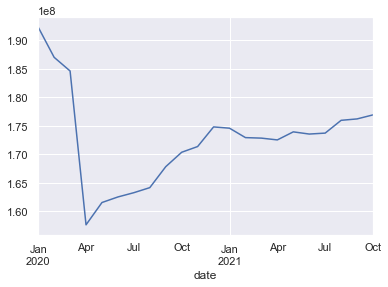

In [330]:
df['transporte']['2020-01-01':].plot()

Vamos pegar os dados somente a partir de abril de 2020

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=566.930, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=564.757, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=564.977, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=572.398, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=566.733, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=566.999, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=568.752, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=568.906, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.320 seconds


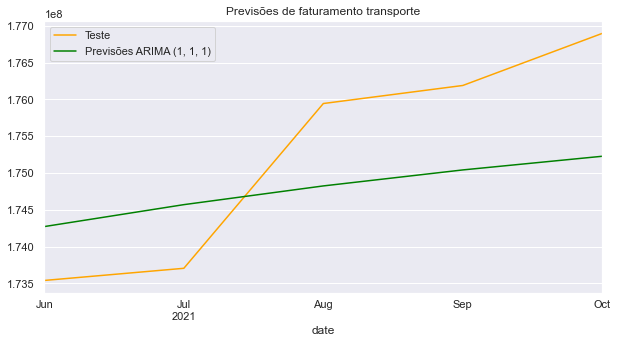

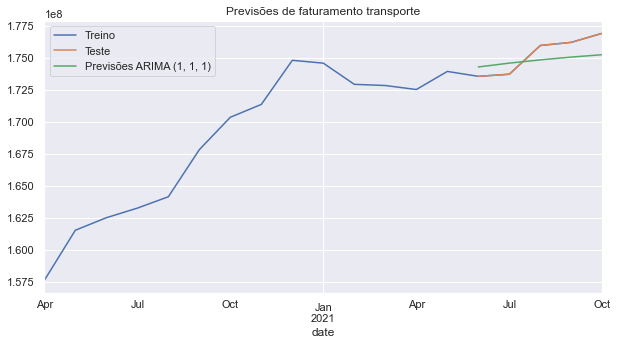

In [331]:
#Aqui usaremos o modelo Arima porque é uma curva sem sazonalidade


df_for = df['transporte']['2020-04-01':] #Faremos o corte em abril de 2020 porque antes dessa data a curva teve uma queda muito abrupta e prever com base nesse comportamento passado levará a resultados incorretos
tamanho = len(df_for)
treino_size = ceil(tamanho*0.7)
treino = df_for[:treino_size]
teste = df_for[treino_size:]


stepwise_fit = auto_arima(df['transporte']['2020-04-01':,], 
                            start_p=0, start_q=0,
                            max_p=6, max_q=6, 
                            seasonal=False,
                            trace=True,
                            error_action='ignore',   
                            suppress_warnings=True,  
                            stepwise=True)


order= (1,1,1) # O modelo ótimo pelo auto arima era o de ordem (1,1,0) porém usaremos o (1,1,1) porque adiciondo um parametro de média móvel o nosso modelo captura melhor o comportamento da curva
smodel = ARIMA(treino, order = order)
sresults = smodel.fit()


# Definindo onde começa e termina
start = len(treino)
end = len(treino) + len(teste) - 1

# calculando as predições
predicts = sresults.predict(start = start, 
                        end = end, 
                        dynamic = True, 
                        typ='levels').rename(f'Previsões ARIMA transporte {(order)}')

# Ajustando os indexs
predicts.index = teste.index

smodel_final = ARIMA(df_for, order = order)
sresults_final = smodel_final.fit()

dicio_models_tunning['transporte'] = (sresults,predicts,df_for,treino,teste,sresults_final)


# Finalzamente fazendo os gráficos 

#posição 4 tem a base de teste
dicio_models_tunning['transporte'][4].plot(label='Teste',legend=True,figsize=(10,5),c='orange')
#posição 1 tem os valores preditos
dicio_models_tunning['transporte'][1].plot(label=f'Previsões ARIMA {order}',legend=True,figsize=(10,5),color='green')
plt.title(f'Previsões de faturamento transporte')
plt.show()

#posição 2 tem a base de treino
dicio_models_tunning['transporte'][2].plot(label='Treino',legend=True,figsize=(10,5)) #coloquei dessa forma somente para a pontinha do gráfico não ficar cortada (entre treino e teste)
dicio_models_tunning['transporte'][4].plot(label='Teste',legend=True,figsize=(10,5))
dicio_models_tunning['transporte'][1].plot(label=f'Previsões ARIMA {order}',legend=True,figsize=(10,5))
plt.title(f'Previsões de faturamento transporte')
plt.show()

O modelo ARIMA (1,1,1) foi o que se ajustou melhor, apesar de ainda não estar muito bom

In [332]:
print('AIC após o tunning: ',dicio_models_tunning['transporte'][0].aic)
print('AIC antes o tunning',dicio_models['transporte'][0].aic)

AIC após o tunning:  412.6216308225279
AIC antes o tunning 2173.3969515181734


### 3.9 Usando os modelos com os ajustes e prever os resultados até 2022

In [333]:
predictions_list = []

for model in df.columns[:-1]:
    predictions = dicio_models_tunning[model][5].get_forecast(steps = 14)
    predictions_list.append(predictions.predicted_mean)



df_final = pd.concat((predictions_list[0],predictions_list[1],predictions_list[2],predictions_list[3],predictions_list[4]),axis=1)
df_final.columns = df.columns[:-1]
df_final

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
2021-11-01,2.028110e+09,-1.942806e+05,-3413.296348,2.628704e+07,1.771303e+08
2021-12-01,2.075362e+09,-6.350194e+05,184740.899410,2.630843e+07,1.773320e+08
2022-01-01,2.037520e+09,-1.296588e+06,172794.411234,2.632983e+07,1.775076e+08
2022-02-01,2.041653e+09,-2.086081e+06,-3413.296348,2.635122e+07,1.776604e+08
2022-03-01,2.023583e+09,-2.870946e+06,-3413.296348,2.637262e+07,1.777934e+08
2022-04-01,2.046135e+09,-3.516598e+06,176217.217875,2.639401e+07,1.779092e+08
2022-05-01,2.033902e+09,-3.924055e+06,188485.027249,2.641541e+07,1.780100e+08
2022-06-01,2.014163e+09,-4.693380e+06,-3413.296348,2.643680e+07,1.780977e+08
2022-07-01,1.998397e+09,-4.961156e+06,191775.214875,2.645819e+07,1.781741e+08
2022-08-01,2.026992e+09,-5.227892e+06,-3413.296348,2.647959e+07,1.782405e+08


### 3.10 Criando uma coluna para a soma das previsões de cada mês (nov-21 a dez-22)

In [334]:
df_final['Previsão soma produtos'] = df_final.sum(axis=1)
df_final

produto,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte,Previsão soma produtos
2021-11-01,2.028110e+09,-1.942806e+05,-3413.296348,2.628704e+07,1.771303e+08,2.231330e+09
2021-12-01,2.075362e+09,-6.350194e+05,184740.899410,2.630843e+07,1.773320e+08,2.278552e+09
2022-01-01,2.037520e+09,-1.296588e+06,172794.411234,2.632983e+07,1.775076e+08,2.240234e+09
2022-02-01,2.041653e+09,-2.086081e+06,-3413.296348,2.635122e+07,1.776604e+08,2.243575e+09
2022-03-01,2.023583e+09,-2.870946e+06,-3413.296348,2.637262e+07,1.777934e+08,2.224874e+09
2022-04-01,2.046135e+09,-3.516598e+06,176217.217875,2.639401e+07,1.779092e+08,2.247098e+09
2022-05-01,2.033902e+09,-3.924055e+06,188485.027249,2.641541e+07,1.780100e+08,2.234592e+09
2022-06-01,2.014163e+09,-4.693380e+06,-3413.296348,2.643680e+07,1.780977e+08,2.214001e+09
2022-07-01,1.998397e+09,-4.961156e+06,191775.214875,2.645819e+07,1.781741e+08,2.198260e+09
2022-08-01,2.026992e+09,-5.227892e+06,-3413.296348,2.647959e+07,1.782405e+08,2.226481e+09


### 3.11 Plotando o gráfico com o total de vendas já realizadas e as previões dos 14 meses (nov/21 a dez/22) usando o modelo considerando o valor total de venda e a soma dos modelos de cada produto

C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\gabri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Volume de previsto comparativo')

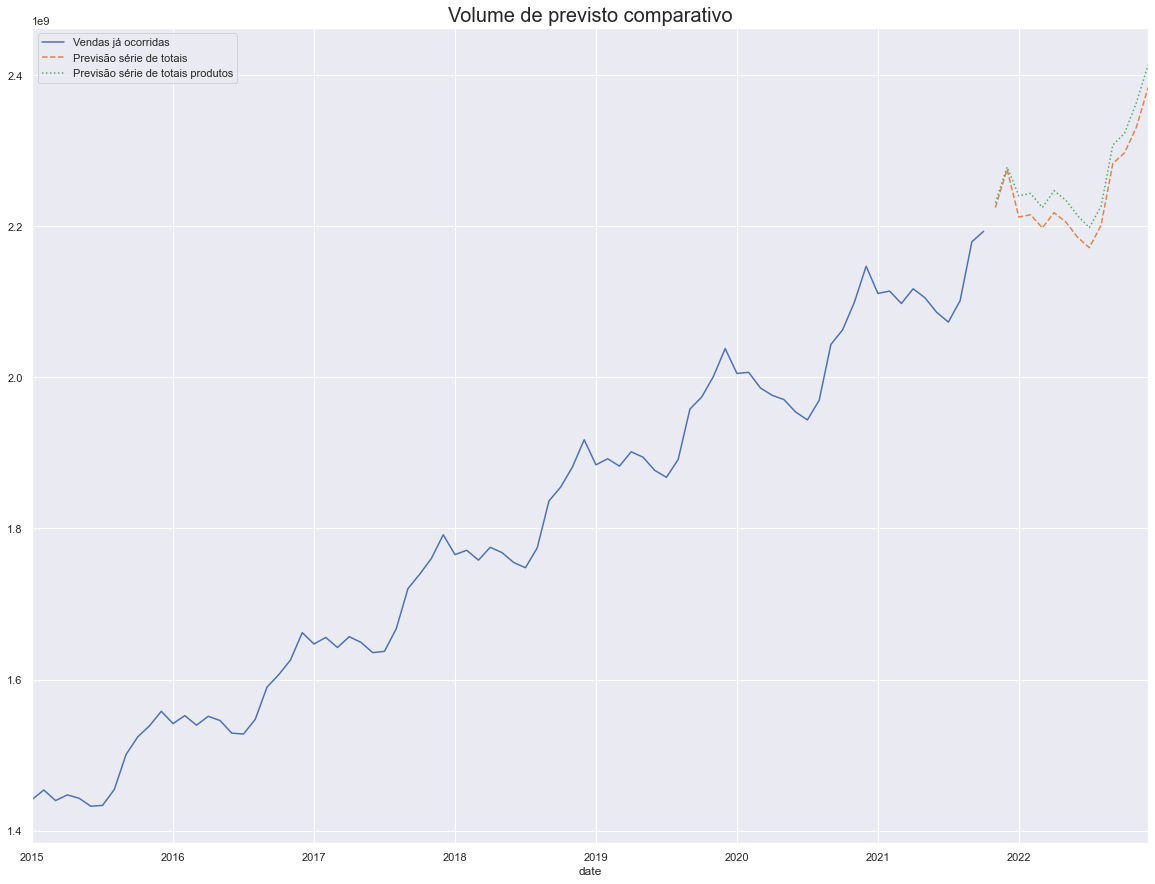

In [335]:
periods = 14 #meses para prever nov,dez/21 e 2022 inteiro

order= (0,0,0)
seasaonal_order = (2,1,2,12)

smodel = SARIMAX(df_cut, order = order, seasonal_order = seasaonal_order)
sresults = smodel.fit()

predictions = sresults.get_forecast(steps = periods)

ax = df_cut.plot(label='Vendas já ocorridas',figsize=(20,15));
predictions.predicted_mean.plot(label='Previsão série de totais',ax=ax,ls='--');
df_final['Previsão soma produtos'].plot(label='Previsão série de totais produtos',ax=ax,ls=':');


ax.legend()
ax.set_title('Volume de previsto comparativo',fontsize=20)

## 4. Conclusão

A previsão do total de vendas para os próximos 14 meses usando a soma de cada previsão dos produto apresentou um comportamento próximo ao estimado usando somente a série do faturamento total mês a mês. Pelo gráfico acima percebemos que a modelo usando o faturamento total mês a mês parece ter capturado melhor o comportamento da curva dos valores já existentem. Isso acontece em grande parte porque nas séries de saúde, bonificação e transporte foi encontrado um modelo ótimo que poderia ser bastante otimizado com técnicas que deixariam a série mais estacionaria (média móvel, log, exp, dentre outras). No entanto, como o ajuste da serie de produto alimentício (maior relevância) foi efetivo, os efeitos dos outros produtos não prejudicam tanto a previsão do faturamento total.

Considerando que o problema acima fosse em uma empresa real, seria mais efetivo prever o faturamento total usando cada produto individualmente, já que são somente 5 produtos e é possível otimizar o modelo para cada produto sem tanto gasto de tempo. Caso o volume de produtos fosse maior (15,20 produtos) seria mais prudente prever o faturamento total com base no valor de vendas mês a mês dos produtos de maior relevância já que o gasto de tempo com a modelagem seria extenso e a modelagem ótima de produtos com baixa representatividade no faturamento não alteraria o valor final de forma significativa.